In [92]:
# After DigitalSreeni's U-net tutorial: https://youtu.be/azM57JuQpQI
# Training data set for medical images can be found here : https://www.kaggle.com/c/data-science-bowl-2018/data
# Aerial images data set : https://www.tugraz.at/index.php?id=22387
# Using TensorFlow Keras

In [24]:
import tensorflow as tf
import os
import numpy as np
import random
from tqdm import tqdm
from skimage.io import imread, imshow
import matplotlib.pyplot as plt
from cv2 import cv2

In [59]:
# Input images size

IMG_WIDTH = 250
IMG_HEIGHT = 375
IMG_CHANNELS = 3

# Input paths
DST_PARENT_DIR = './drone_dataset_resized/'
PARENT_DIR = './semantic_drone_dataset/'
ORIGINAL_PATH = 'original_images/'
SEGMENTED_PATH = 'label_images/'
DST_SEGMENTED_PATH = "label_images_semantic/"

RESULTS_PATH = "./Results/"
LABEL_TYPES_PATH = "OnlyRoad/"
#consistent randomness and good-luck charm
seed = 42
np.random.seed = seed

Importing the data

In [64]:
train_ids = os.listdir(PARENT_DIR + ORIGINAL_PATH)

X_train = np.zeros((len(train_ids), IMG_WIDTH,IMG_HEIGHT, IMG_CHANNELS), dtype = np.uint8)
Y_train = np.zeros((len(train_ids),IMG_WIDTH,IMG_HEIGHT), dtype = np.bool)

Defining the train and control set +  Pre-processing the train data to fit into our U-net

In [65]:

def resize_original():
    ids = os.listdir(PARENT_DIR + ORIGINAL_PATH)
    for n, id_ in tqdm(enumerate(ids), total=len(ids)):
        # path = "%s%s%03d.jpg" % (PARENT_DIR, ORIGINAL_PATH, n)
        path = PARENT_DIR + ORIGINAL_PATH + id_
        img_ = cv2.imread(path, cv2.IMREAD_COLOR)
        resized_img = cv2.resize(img_, (IMG_WIDTH, IMG_HEIGHT), interpolation=cv2.INTER_AREA)

        # X_train[n] = resized_img
        #path = "%s/%s/%03d.jpg" % (DST_PARENT_DIR, DST_ORIGINAL_PATH, n)
        #cv2.imwrite(path, resized_img)
        cv2.imwrite(DST_PARENT_DIR + ORIGINAL_PATH + id_.split('.')[0] + ".png", resized_img)

def resize_segmented():
    ids = os.listdir(PARENT_DIR + SEGMENTED_PATH)
    for n, id_ in tqdm(enumerate(ids), total=len(ids)):
        #path = "%s%s%03d.png" % (PARENT_DIR, SEGMENTED_PATH, n)
        path = PARENT_DIR + SEGMENTED_PATH + id_.split('.')[0] + '.png'
        #print(path)
        img = cv2.imread(path, cv2.IMREAD_COLOR)

        resized_img = cv2.resize(img, (IMG_WIDTH, IMG_HEIGHT), interpolation=cv2.INTER_NEAREST)
        gray_img = cv2.cvtColor(resized_img, cv2.COLOR_BGR2GRAY)
        for i in range(0, resized_img.shape[0]):
            for j in range(0,resized_img.shape[1]):
                # pick a class "paved area"
                (b,g,r) = resized_img[i,j];
                if (b == 128 and g == 64 and r == 128):
                    gray_img[i, j] = 255

                else:
                    gray_img[i,j] = 0

        # if(n == 10):
        #     exit(0)
        # Y_train[n] = gray_img
        #path = "%s/%s/%03d.jpg" % (DST_PARENT_DIR, DST_SEGMENTED_PATH, n)
        cv2.imwrite(DST_PARENT_DIR + DST_SEGMENTED_PATH + id_.split('.')[0] + ".png", gray_img)

In [66]:
#resize_segmented()
#resize_original()

In [67]:
for n, id_ in tqdm(enumerate(train_ids), total=len(train_ids)):
    #Actual train image
    #print(DST_PARENT_DIR + ORIGINAL_PATH + id_)
    img = imread(DST_PARENT_DIR + ORIGINAL_PATH + id_.split(".")[0] + '.png')[:, :, :IMG_CHANNELS]
    X_train[n] = img
    mask = imread(DST_PARENT_DIR + DST_SEGMENTED_PATH + id_.split(".")[0] + '.png')
    Y_train[n] = mask

100%|██████████| 400/400 [00:01<00:00, 256.47it/s]


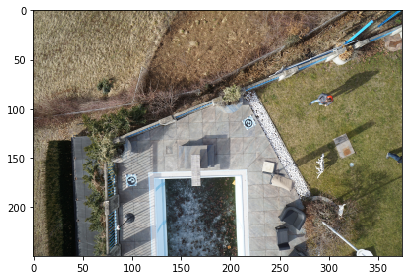

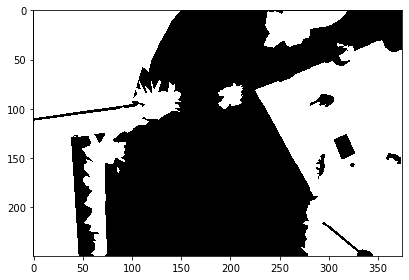

In [68]:
image_we = random.randint(0, len(train_ids))
#original
imshow(X_train[image_we])
plt.show()
#control
imshow(np.squeeze(Y_train[image_we]))
plt.show()


Model creation after U-net diagram (I need to find out how to import an image here :) )

In [70]:
# Input layer
inputs = tf.keras.layers.Input((IMG_WIDTH, IMG_HEIGHT, IMG_CHANNELS))

In [71]:
# Converts pixel value to float, and normalizes it
s = tf.keras.layers.Lambda(lambda x: x/255)(inputs)

First convolutional layers, size = 16 of  (3x3) convolutional kernels 
                                          -initializing them with 'he_normal' kernel_initializer
                                          
After each convolution we drop out some of output's data to reduce/prevent overfitting
MaxPooling is user to 'contract' the input reducing its size and combating overfitting

In [72]:
c1 = tf.keras.layers.Conv2D(16, (3,3), activation = 'relu', kernel_initializer='he_normal', padding = 'same')(inputs)
c1 = tf.keras.layers.Dropout(0.1)(c1)
c1 = tf.keras.layers.Conv2D(16, (3,3), activation = 'relu', kernel_initializer='he_normal', padding = 'same')(c1)
p1 = tf.keras.layers.MaxPooling2D((2,2))(c1)

In [73]:
c2 = tf.keras.layers.Conv2D(32, (3,3), activation = 'relu', kernel_initializer='he_normal', padding = 'same')(p1)
c2 = tf.keras.layers.Dropout(0.1)(c2)
c2 = tf.keras.layers.Conv2D(32, (3,3), activation = 'relu', kernel_initializer='he_normal', padding = 'same')(c2)
p2 = tf.keras.layers.MaxPooling2D((2,2))(c2)

In [74]:
c3 = tf.keras.layers.Conv2D(64, (3,3), activation = 'relu', kernel_initializer='he_normal', padding = 'same')(p2)
c3 = tf.keras.layers.Dropout(0.2)(c3)
c3 = tf.keras.layers.Conv2D(64, (3,3), activation = 'relu', kernel_initializer='he_normal', padding = 'same')(c3)
p3 = tf.keras.layers.MaxPooling2D((2,2))(c3)

In [75]:
c4 = tf.keras.layers.Conv2D(128, (3,3), activation = 'relu', kernel_initializer='he_normal', padding = 'same')(p3)
c4 = tf.keras.layers.Dropout(0.2)(c4)
c4 = tf.keras.layers.Conv2D(128, (3,3), activation = 'relu', kernel_initializer='he_normal', padding = 'same')(c4)
p4 = tf.keras.layers.MaxPooling2D((2,2))(c4)

In [76]:
c5 = tf.keras.layers.Conv2D(256, (3,3), activation = 'relu', kernel_initializer='he_normal', padding = 'same')(p4)
c5 = tf.keras.layers.Dropout(0.3)(c5)
c5 = tf.keras.layers.Conv2D(256, (3,3), activation = 'relu', kernel_initializer='he_normal', padding = 'same')(c5)

From this point we should start the expansion path of the processed data
    Before further processing of the expanded data, we concatenate its with the previous layer 

In [78]:
u6 = tf.keras.layers.Conv2DTranspose(128, (2,2), strides=(2, 2), padding='same')(c5)
u6 = tf.keras.layers.ZeroPadding2D(padding=((0,1),(0,0)))(u6)
u6 = tf.keras.layers.concatenate([u6, c4])
c6 = tf.keras.layers.Conv2D(128, (3,3),activation = 'relu', kernel_initializer='he_normal', padding = 'same')(u6)
c6 = tf.keras.layers.Dropout(0.2)(c6)
c6 = tf.keras.layers.Conv2D(128, (3,3),activation = 'relu', kernel_initializer='he_normal', padding = 'same')(c6)

In [80]:
u7 = tf.keras.layers.Conv2DTranspose(64, (2,2), strides=(2, 2), padding='same')(c6)
u7 = tf.keras.layers.ZeroPadding2D(padding=((0,0),(0,1)))(u7)
u7 = tf.keras.layers.concatenate([u7, c3])
c7 = tf.keras.layers.Conv2D(64, (3,3),activation = 'relu', kernel_initializer='he_normal', padding = 'same')(u7)
c7 = tf.keras.layers.Dropout(0.2)(c7)
c7 = tf.keras.layers.Conv2D(64, (3,3),activation = 'relu', kernel_initializer='he_normal', padding = 'same')(c7)


In [81]:
u8 = tf.keras.layers.Conv2DTranspose(32, (2,2), strides=(2, 2), padding='same')(c7)
u8 = tf.keras.layers.ZeroPadding2D(padding=((0,1),(0,1)))(u8)
u8 = tf.keras.layers.concatenate([u8, c2])
c8 = tf.keras.layers.Conv2D(32, (3,3),activation = 'relu', kernel_initializer='he_normal', padding = 'same')(u8)
c8 = tf.keras.layers.Dropout(0.1)(c8)
c8 = tf.keras.layers.Conv2D(32, (3,3),activation = 'relu', kernel_initializer='he_normal', padding = 'same')(c8)


In [83]:
u9 = tf.keras.layers.Conv2DTranspose(16, (2,2), strides=(2, 2), padding='same')(c8)
u9 = tf.keras.layers.ZeroPadding2D(padding=((0,0),(0,1)))(u9)
u9 = tf.keras.layers.concatenate([u9, c1], axis=3)
c9 = tf.keras.layers.Conv2D(16, (3,3),activation = 'relu', kernel_initializer='he_normal', padding = 'same')(u9)
c9 = tf.keras.layers.Dropout(0.1)(c9)
c9 = tf.keras.layers.Conv2D(16, (3,3),activation = 'relu', kernel_initializer='he_normal', padding = 'same')(c9)


In [84]:
outputs = tf.keras.layers.Conv2D(1, (1, 1), activation='sigmoid')(c9)

model = tf.keras.Model(inputs=[inputs], outputs=[outputs])
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_4 (InputLayer)            [(None, 250, 375, 3) 0                                            
__________________________________________________________________________________________________
conv2d_31 (Conv2D)              (None, 250, 375, 16) 448         input_4[0][0]                    
__________________________________________________________________________________________________
dropout_15 (Dropout)            (None, 250, 375, 16) 0           conv2d_31[0][0]                  
__________________________________________________________________________________________________
conv2d_32 (Conv2D)              (None, 250, 375, 16) 2320        dropout_15[0][0]                 
____________________________________________________________________________________________

Checkpoints, just in case

In [85]:
#Model checkoints
checkpointer = tf.keras.callbacks.ModelCheckpoint('model_for_nuclei.h5', verbose = 1, save_best_only = True )

We send callbacks for aditional control:
    EarlyStopping if the monitor does not improve over "patience" epochs
    TensorBoard is a visualization tool saved in log_dir inside parent directory

In [86]:
#Callbacks
callbacks =[
   # tf.keras.callbacks.EarlyStopping(patience=2, monitor='val_loss'),
   tf.keras.callbacks.TensorBoard(log_dir='logs')
]

In [87]:
results = model.fit(X_train,Y_train,validation_split=0.5, batch_size = 16, epochs = 25, callbacks=callbacks)

Epoch 1/25
13/13 [==============================] - 31s 2s/step - loss: 2.5909 - accuracy: 0.7446 - val_loss: 1.3407 - val_accuracy: 0.8148
Epoch 2/25
13/13 [==============================] - 8s 598ms/step - loss: 1.0006 - accuracy: 0.7398 - val_loss: 0.5131 - val_accuracy: 0.7899
Epoch 3/25
13/13 [==============================] - 8s 598ms/step - loss: 0.5678 - accuracy: 0.7918 - val_loss: 0.4458 - val_accuracy: 0.8092
Epoch 4/25
13/13 [==============================] - 8s 599ms/step - loss: 0.4694 - accuracy: 0.7817 - val_loss: 0.3769 - val_accuracy: 0.8310
Epoch 5/25
13/13 [==============================] - 8s 597ms/step - loss: 0.4168 - accuracy: 0.8142 - val_loss: 0.3587 - val_accuracy: 0.8403
Epoch 6/25
13/13 [==============================] - 8s 596ms/step - loss: 0.3915 - accuracy: 0.8180 - val_loss: 0.3384 - val_accuracy: 0.8488
Epoch 7/25
13/13 [==============================] - 8s 596ms/step - loss: 0.3865 - accuracy: 0.8195 - val_loss: 0.3308 - val_accuracy: 0.8552
Epoch 8/

Testing the model

In [88]:
idx = random.randint(0, len(X_train))

preds_train = model.predict(X_train, verbose=1)
#preds_val = model.predict(X_train[int(X_train.shape[0])], verbose=1)
# preds_test = model.predict(X_test, verbose = 1)

#Binarizationing the results
preds_train_t = (preds_train > 0.5).astype(np.uint8)
#preds_val_t = (preds_val > 0.1).astype(np.uint8)
# preds_test_t = (preds_test > 0.5).astype(np.uint8)


13/13 [==============================] - 3s 269ms/step


Printing some results

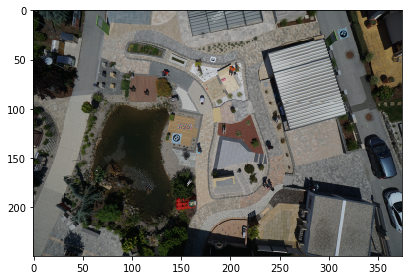

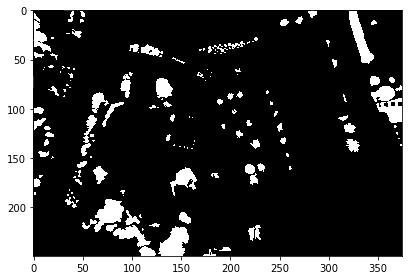

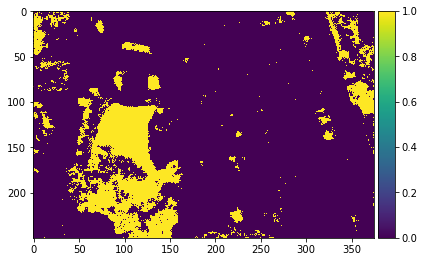

TypeError: Expected Ptr<cv::UMat> for argument 'img'

In [95]:
#random training sample
i = random.randint(0, len(preds_train_t))
imshow(X_train[i])
plt.show()
imshow(np.squeeze(Y_train[i]))
plt.show()
imshow(np.squeeze(preds_train_t[i]))
plt.show()

trainPath = "%s%sstrain%03d.png" % (RESULTS_PATH, LABEL_TYPES_PATH, i)
controlPath = "%s%scontrolMask%03d.png" % (RESULTS_PATH, LABEL_TYPES_PATH, i)
predictionPath = "%s%sprediction%03d.png" % (RESULTS_PATH, LABEL_TYPES_PATH, i)
cv2.imwrite(trainPath, X_train[i])
cv2.imwrite(controlPath, Y_train[i])
cv2.imwrite(predictionPath, preds_train_t[i])

#random validation sample
# i = random.randint(0, len(preds_val_t))
# imshow(X_train[int(X_train.shape[0]*0.9):][i])
# plt.show()
# imshow(np.squeeze(Y_train[int(Y_train.shape[0]*0.9):][i]))
# plt.show()
# imshow(np.squeeze(preds_val_t[i]))
# plt.show()